5/5 [==============================] - 0s 6ms/step
Время обучения: 27.49 сек
Время предсказания: 0.4016 сек
MSE: 3.6912
MAE: 1.4265


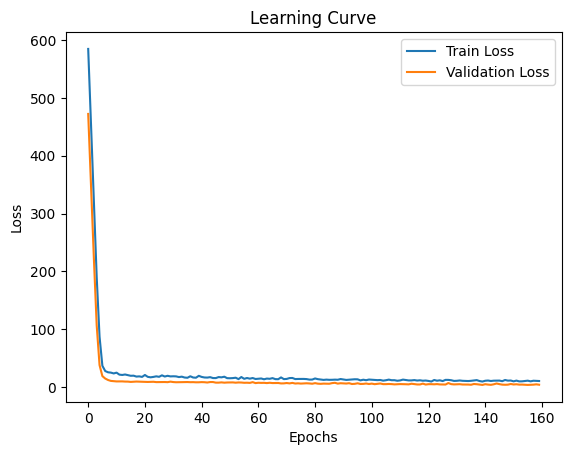

In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time

# 1. Загрузка и подготовка данных
df = pd.read_excel("ENB2012_data.xlsx")
df.columns = [
    'Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area',
    'Overall_Height', 'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution',
    'Heating_Load', 'Cooling_Load'
]

X = df.iloc[:, :8].values
y = df[['Heating_Load', 'Cooling_Load']].values

# 2. Масштабирование данных
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 3. Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Создание Transformer модели
def transformer_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # Добавляем временную ось для совместимости с Transformer
    x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
    
    # Позиционные эмбеддинги
    position_embedding = layers.Dense(64)(x)
    position_embedding = layers.LayerNormalization()(position_embedding)
    
    # Multi-Head Attention
    attention = layers.MultiHeadAttention(
        num_heads=4, 
        key_dim=16
    )(position_embedding, position_embedding)
    
    # Удаляем временную ось
    x = layers.Lambda(lambda x: tf.squeeze(x, axis=1))(attention)
    
    # Feed Forward Network
    x = layers.LayerNormalization()(x + tf.squeeze(position_embedding, axis=1))
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    
    # Выходной слой
    outputs = layers.Dense(2)(x)
    
    return Model(inputs=inputs, outputs=outputs)

# 5. Сборка и компиляция модели
model = transformer_model(input_shape=(8,))
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mae']
)

# 6. Обучение модели
start_time = time.time()
history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
    ],
    verbose=0
)
train_time = time.time() - start_time

# 7. Предсказание и оценка
start_pred = time.time()
y_pred = model.predict(X_test)
pred_time = time.time() - start_pred

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# 8. Вывод результатов
print(f"Время обучения: {train_time:.2f} сек")
print(f"Время предсказания: {pred_time:.4f} сек")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")

# 9. Визуализация обучения
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()